In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [2]:
def file_reader(basedir, filename):
    if filename.endswith('.csv'):
        try:
            df = pd.read_csv(basedir + filename, header=15)
        except:
            df = pd.read_csv(basedir + filename, encoding='euc-kr', header=15)
    elif filename.endswith('.xlsx'):
        try:
            df = pd.read_excel(basedir + filename, header=16)
        except:
            df = pd.read_excel(basedir + filename, encoding='euc-kr', header=16)
    else:
        print('error')
    
    return df

In [3]:
def read_data():
    basedir = './국토교통부_실거래가_공개시스템/'
    filenames = os.listdir(basedir)
    
    apart_trade_files = [filename for filename in filenames if filename.startswith('아파트(매매)')]
    apart_lease_files = [filename for filename in filenames if filename.startswith('아파트(전월세)')]
    multiplex_trade_files = [filename for filename in filenames if filename.startswith('연립다세대(매매)')]
    multiplex_lease_files = [filename for filename in filenames if filename.startswith('연립다세대(전월세)')]
    officetel_trade_files = [filename for filename in filenames if filename.startswith('오피스텔(매매)')]
    officetel_lease_files = [filename for filename in filenames if filename.startswith('오피스텔(전월세)')]
    
    #
    apart_trade_dfs_list = []
    for filename in apart_trade_files:
        df = file_reader(basedir, filename)
        apart_trade_dfs_list.append(df)
    apart_trade_df = pd.concat(apart_trade_dfs_list).reset_index(drop=True)
    
    #
    apart_lease_dfs_list = []
    for filename in apart_lease_files:
        df = file_reader(basedir, filename)
        apart_lease_dfs_list.append(df)
    apart_lease_df = pd.concat(apart_lease_dfs_list).reset_index(drop=True)
    
    #
    multiplex_trade_dfs_list = []
    for filename in multiplex_trade_files:
        df = file_reader(basedir, filename)
        multiplex_trade_dfs_list.append(df)
    multiplex_trade_df = pd.concat(multiplex_trade_dfs_list).reset_index(drop=True)
    
    #
    multiplex_lease_dfs_list = []
    for filename in multiplex_lease_files:
        df = file_reader(basedir, filename)
        multiplex_lease_dfs_list.append(df)
    multiplex_lease_df = pd.concat(multiplex_lease_dfs_list).reset_index(drop=True)
    
    #
    officetel_trade_dfs_list = []
    for filename in officetel_trade_files:
        df = file_reader(basedir, filename)
        officetel_trade_dfs_list.append(df)
    officetel_trade_df = pd.concat(officetel_trade_dfs_list).reset_index(drop=True)
    
    #
    officetel_lease_dfs_list = []
    for filename in officetel_lease_files:
        df = file_reader(basedir, filename)
        officetel_lease_dfs_list.append(df)
    officetel_lease_df = pd.concat(officetel_lease_dfs_list).reset_index(drop=True)
    
    
    return apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df

In [4]:
%%time
apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df\
= read_data()

c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  if __name__ == '__main__':
c:\users\max6296\ml\lib\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 2min 52s


# From previous EDA and Preprocessing

In [5]:
apart_lease_df.drop(apart_lease_df[apart_lease_df['전용면적(㎡)'].isna()].index, inplace=True)

In [6]:
multiplex_trade_df.loc[multiplex_trade_df[multiplex_trade_df['건축년도'].isna()].index, '건축년도'] = 1971
multiplex_lease_df.drop(multiplex_lease_df[multiplex_lease_df['층'].isna()].index, inplace=True)

In [7]:
# 모든 df 도로명 빈 칸 null 로 교체

def replace_empty_to_null(df):
    df = df.copy()
    
    empty_df = df[df['도로명'] == ' ']
    
    df.loc[empty_df.index, '도로명'] = np.nan
    
    return df

In [8]:
apart_trade_df = replace_empty_to_null(apart_trade_df)
apart_lease_df = replace_empty_to_null(apart_lease_df)
multiplex_trade_df = replace_empty_to_null(multiplex_trade_df)
multiplex_lease_df = replace_empty_to_null(multiplex_lease_df)
officetel_trade_df = replace_empty_to_null(officetel_trade_df)
officetel_lease_df = replace_empty_to_null(officetel_lease_df)

In [9]:
multiplex_lease_df.loc[multiplex_lease_df[multiplex_lease_df['건축년도'].isna()].index, '건축년도'] = 1971

In [10]:
# 건축년도가 null 인 row 들에 있는 주소들 중에서, 같은 주소지만 건축년도 값이 있는 주소는 null 을 채워넣고, 없는 주소는 df 에서 제거.
# 추가적으로, 한 주소지, 단지이름에 건축년도가 두 가지 이상 있는지도 조사함.

def bltyear_fill_and_remove_null(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'] + df['번지'] + df['단지명']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    unique_addrs = bltyear_null_df['temp_full_addr'].unique()
    
    concat_list = []
    for addr in unique_addrs:
        addr_df = df[df['temp_full_addr'] == addr]
        if addr_df['건축년도'].isna().sum() != addr_df.shape[0]:
            if addr_df['건축년도'].std() != 0:
                print('건축년도가 두 가지 이상인 주소가 있음.')
            
            addr_df['건축년도'].fillna(addr_df['건축년도'].mean(), inplace=True)
            
            concat_list.append(addr_df)
    
    df.drop(columns=['temp_full_addr'], inplace=True)
    
    if len(concat_list) > 0:
        concat_df = pd.concat(concat_list)
    else:
        return df
    
    #return concat_df
    
    df.loc[concat_df.index, '건축년도'] = concat_df['건축년도']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    df.drop(bltyear_null_df.index, inplace=True)
        
    return df.reset_index(drop=True)

In [11]:
officetel_trade_df = bltyear_fill_and_remove_null(officetel_trade_df)
officetel_lease_df = bltyear_fill_and_remove_null(officetel_lease_df)

In [12]:
def trade_dfs_change_dtype(df):
    df = df.copy()
    
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(str)
    df['거래금액(만원)'] = pd.to_numeric(df['거래금액(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [13]:
apart_trade_df = trade_dfs_change_dtype(apart_trade_df)
multiplex_trade_df = trade_dfs_change_dtype(multiplex_trade_df)
officetel_trade_df = trade_dfs_change_dtype(officetel_trade_df)

In [14]:
def lease_dfs_change_dtype(df):
    df = df.copy()
    
    df['보증금(만원)'] = df['보증금(만원)'].apply(str)
    df['월세(만원)'] = df['월세(만원)'].apply(str)
    df['보증금(만원)'] = pd.to_numeric(df['보증금(만원)'].str.replace(',', ''))
    df['월세(만원)'] = pd.to_numeric(df['월세(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [15]:
apart_lease_df = lease_dfs_change_dtype(apart_lease_df)
multiplex_lease_df = lease_dfs_change_dtype(multiplex_lease_df)
officetel_lease_df = lease_dfs_change_dtype(officetel_lease_df)

In [16]:
def price_per_area_and_year_month(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    elif mode == 'lease':
        df['가격/면적'] = df['보증금(만원)'] / df['전용면적(㎡)']
    
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    df['month'] = pd.to_numeric(df['계약년월'].astype('str').str[4:])
    
    return df   

In [17]:
apart_trade_df = price_per_area_and_year_month(apart_trade_df)
multiplex_trade_df = price_per_area_and_year_month(multiplex_trade_df)
officetel_trade_df = price_per_area_and_year_month(officetel_trade_df)

In [18]:
apart_lease_df = price_per_area_and_year_month(apart_lease_df, mode='lease')
multiplex_lease_df = price_per_area_and_year_month(multiplex_lease_df, mode='lease')
officetel_lease_df = price_per_area_and_year_month(officetel_lease_df, mode='lease')

In [19]:
def si_gu(df):
    df = df.copy()
    
    df['시'] = df['시군구'].str.split(' ').apply(lambda x: x[0])
    df['구'] = df['시군구'].str.split(' ').apply(lambda x: x[1])
    
    return df

In [20]:
apart_trade_df = si_gu(apart_trade_df)
apart_lease_df = si_gu(apart_lease_df)
multiplex_trade_df = si_gu(multiplex_trade_df)
multiplex_lease_df = si_gu(multiplex_lease_df)
officetel_trade_df = si_gu(officetel_trade_df)
officetel_lease_df = si_gu(officetel_lease_df)

In [21]:
def remove_zero_price(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df = df[df['거래금액(만원)'] != 0].reset_index(drop=True)
    elif mode == 'lease':
        df = df[df['보증금(만원)'] != 0].reset_index(drop=True)
    
    return df

In [22]:
apart_trade_df = remove_zero_price(apart_trade_df)
apart_lease_df = remove_zero_price(apart_lease_df, mode='lease')
multiplex_trade_df = remove_zero_price(multiplex_trade_df)
multiplex_lease_df = remove_zero_price(multiplex_lease_df, mode='lease')
officetel_trade_df = remove_zero_price(officetel_trade_df)
officetel_lease_df = remove_zero_price(officetel_lease_df, mode='lease')

In [23]:
def remove_zero_area(df):
    df = df.copy()
    
    df = df[df['전용면적(㎡)'] != 0].reset_index(drop=True)
    
    return df

In [24]:
apart_trade_df = remove_zero_area(apart_trade_df)
apart_lease_df = remove_zero_area(apart_lease_df)
multiplex_trade_df = remove_zero_area(multiplex_trade_df)
multiplex_lease_df = remove_zero_area(multiplex_lease_df)
officetel_trade_df = remove_zero_area(officetel_trade_df)
officetel_lease_df = remove_zero_area(officetel_lease_df)

In [25]:
def correct_lease_type(df):
    df = df.copy()
    
    wrong_df = df[(df['전월세구분'] == '월세') & (df['월세(만원)'] == 0)]
    
    df.loc[wrong_df.index, '전월세구분'] = '전세'
    
    wrong_df2 = df[(df['전월세구분'] == '전세') & (df['월세(만원)'] != 0)]
    
    df.loc[wrong_df2.index, '전월세구분'] = '월세'
    
    return df

In [26]:
apart_lease_df = correct_lease_type(apart_lease_df)
multiplex_lease_df = correct_lease_type(multiplex_lease_df)
officetel_lease_df = correct_lease_type(officetel_lease_df)

In [27]:
'''apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
multiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
multiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
officetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
officetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)'''

"apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)\napart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)\nmultiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)\nmultiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)\nofficetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)\nofficetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)"

# EDA & Preprocessing 11

# 이상치 제거 ver 2

In [29]:
apart_trade_df['target_log_transformed'] = apart_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
apart_lease_df['target_log_transformed'] = apart_lease_df['보증금(만원)'].apply(lambda x: np.log(x))
multiplex_trade_df['target_log_transformed'] = multiplex_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
multiplex_lease_df['target_log_transformed'] = multiplex_lease_df['보증금(만원)'].apply(lambda x: np.log(x))
officetel_trade_df['target_log_transformed'] = officetel_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
officetel_lease_df['target_log_transformed'] = officetel_lease_df['보증금(만원)'].apply(lambda x: np.log(x))

In [68]:
# Tukey의 기법을 사용하여 각 동 별 이상치 (outlier) 검색 후 제거 (가격)

def find_and_remove_Tukey_outliers_ver2_price_per_dong(df):
    df = df.copy()
    
    unique_dongs = df['시군구'].unique()
    
    count = 0
    dfs_list = []
    for dong in unique_dongs:
        dong_df = df[df['시군구'] == dong]
        
        year_val_c = dong_df['year'].value_counts()
        year_val_c_max = year_val_c.max()
        
        year_dfs_list = []
        for year in year_val_c.index:
            year_df = dong_df[dong_df['year'] == year]
            year_df_sample = year_df.sample(n=year_val_c_max, replace=True, random_state=42)
            year_dfs_list.append(year_df_sample)
            
        dong_concat_df = pd.concat(year_dfs_list)
    
        q1 = dong_concat_df['target_log_transformed'].quantile(0.25)
        q3 = dong_concat_df['target_log_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5

        outlier_df = dong_df[(dong_df['target_log_transformed'] < q1 - outlier_step) | (dong_df['target_log_transformed'] > q3 + outlier_step)]

        dong_df.drop(outlier_df.index, inplace=True)
        
        dfs_list.append(dong_df)

        print('{}에서 {}개의 이상치를 찾아서 제거했습니다.'.format(dong, outlier_df.shape[0]))
        
        count += outlier_df.shape[0]
    
    print('총 {}개의 이상치를 찾아서 제거했습니다.'.format(count))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)   
    
    return concat_df

In [69]:
prac_df = find_and_remove_Tukey_outliers_ver2_price_per_dong(apart_trade_df)

서울특별시 강남구 개포동에서 121개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 논현동에서 33개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 대치동에서 530개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 도곡동에서 300개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 삼성동에서 120개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 세곡동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 수서동에서 11개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 신사동에서 53개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 압구정동에서 19개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 역삼동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 일원동에서 64개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 청담동에서 62개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 강일동에서 109개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 고덕동에서 142개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 길동에서 607개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 둔촌동에서 18개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 명일동에서 25개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 상일동에서 208개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 성내동에서 188개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 암사동에서 9개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 천호동에서 245개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 미아동에서 193개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 번동에서 165개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 수유동에서 216개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 우이동에서 8개의 이상치를 찾아서 제거했습니다.
서울특별시 강서구 가양동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시

서울특별시 영등포구 영등포동7가에서 274개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동8가에서 33개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 도원동에서 37개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동빙고동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동자동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 문배동에서 140개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 보광동에서 23개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 산천동에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 서빙고동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신계동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신창동에서 14개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용문동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동2가에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동5가에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로1가에서 6개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로4가에서 7개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이촌동에서 49개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이태원동에서 28개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청암동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청파동1가에서 4개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로1가에서 6개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로2가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로3가에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한남동에서 291개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 효창동에서 14개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 후암동에서 26개의 이상치를 찾아서 제거했습니

In [70]:
prac_df['거래금액(만원)'].describe()

count    1.147287e+06
mean     5.226836e+04
std      3.868994e+04
min      2.300000e+03
25%      2.860000e+04
50%      4.150000e+04
75%      6.278250e+04
max      5.700000e+05
Name: 거래금액(만원), dtype: float64

# 가격/면적 log

In [30]:
apart_trade_df['target/area_log_transformed'] = apart_trade_df['가격/면적'].apply(lambda x: np.log(x))
apart_lease_df['target/area_log_transformed'] = apart_lease_df['가격/면적'].apply(lambda x: np.log(x))
multiplex_trade_df['target/area_log_transformed'] = multiplex_trade_df['가격/면적'].apply(lambda x: np.log(x))
multiplex_lease_df['target/area_log_transformed'] = multiplex_lease_df['가격/면적'].apply(lambda x: np.log(x))
officetel_trade_df['target/area_log_transformed'] = officetel_trade_df['가격/면적'].apply(lambda x: np.log(x))
officetel_lease_df['target/area_log_transformed'] = officetel_lease_df['가격/면적'].apply(lambda x: np.log(x))

In [60]:
def get_dong(x):
    #x is a string
    
    for i in range(10):
        splitted = x.split('{}'.format(i))
        if len(splitted) > 1:
            return splitted[0]
    
    return x

In [61]:
apart_trade_df['동'] = apart_trade_df['시군구'].apply(get_dong)

In [63]:
apart_lease_df['동'] = apart_lease_df['시군구'].apply(get_dong)
multiplex_trade_df['동'] = multiplex_trade_df['시군구'].apply(get_dong)
multiplex_lease_df['동'] = multiplex_lease_df['시군구'].apply(get_dong)
officetel_trade_df['동'] = officetel_trade_df['시군구'].apply(get_dong)
officetel_lease_df['동'] = officetel_lease_df['시군구'].apply(get_dong)

In [64]:
# Tukey의 기법을 사용하여 각 동 별 이상치 (outlier) 검색 후 제거 (가격)

def find_and_remove_Tukey_outliers_ver2_price_per_area_log_per_dong(df):
    df = df.copy()
    
    unique_dongs = df['동'].unique()
    
    count = 0
    dfs_list = []
    for dong in unique_dongs:
        dong_df = df[df['동'] == dong]
        
        year_val_c = dong_df['year'].value_counts()
        year_val_c_max = year_val_c.max()
        print(year_val_c_max)
        
        year_dfs_list = []
        for year in year_val_c.index:
            year_df = dong_df[dong_df['year'] == year]
            year_df_sample = year_df.sample(n=year_val_c_max, replace=True, random_state=42)
            year_dfs_list.append(year_df_sample)
            
        dong_concat_df = pd.concat(year_dfs_list)
    
        q1 = dong_concat_df['target/area_log_transformed'].quantile(0.25)
        q3 = dong_concat_df['target/area_log_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5

        outlier_df = dong_df[(dong_df['target/area_log_transformed'] < q1 - outlier_step)\
                             | (dong_df['target/area_log_transformed'] > q3 + outlier_step)]

        dong_df.drop(outlier_df.index, inplace=True)
        
        dfs_list.append(dong_df)

        print('{}에서 {}개의 이상치를 찾아서 제거했습니다.'.format(dong, outlier_df.shape[0]))
        
        count += outlier_df.shape[0]
    
    print('총 {}개의 이상치를 찾아서 제거했습니다.'.format(count))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)   
    
    return concat_df

In [65]:
prac_df = find_and_remove_Tukey_outliers_ver2_price_per_area_log_per_dong(apart_trade_df)

1566
서울특별시 강남구 개포동에서 204개의 이상치를 찾아서 제거했습니다.
420
서울특별시 강남구 논현동에서 62개의 이상치를 찾아서 제거했습니다.
1207
서울특별시 강남구 대치동에서 480개의 이상치를 찾아서 제거했습니다.
1072
서울특별시 강남구 도곡동에서 123개의 이상치를 찾아서 제거했습니다.
708
서울특별시 강남구 삼성동에서 48개의 이상치를 찾아서 제거했습니다.
214
서울특별시 강남구 세곡동에서 0개의 이상치를 찾아서 제거했습니다.
627
서울특별시 강남구 수서동에서 52개의 이상치를 찾아서 제거했습니다.
104
서울특별시 강남구 신사동에서 6개의 이상치를 찾아서 제거했습니다.
522
서울특별시 강남구 압구정동에서 48개의 이상치를 찾아서 제거했습니다.
825
서울특별시 강남구 역삼동에서 6개의 이상치를 찾아서 제거했습니다.
534
서울특별시 강남구 일원동에서 204개의 이상치를 찾아서 제거했습니다.
536
서울특별시 강남구 청담동에서 65개의 이상치를 찾아서 제거했습니다.
926
서울특별시 강동구 강일동에서 5개의 이상치를 찾아서 제거했습니다.
722
서울특별시 강동구 고덕동에서 0개의 이상치를 찾아서 제거했습니다.
805
서울특별시 강동구 길동에서 171개의 이상치를 찾아서 제거했습니다.
1090
서울특별시 강동구 둔촌동에서 46개의 이상치를 찾아서 제거했습니다.
1209
서울특별시 강동구 명일동에서 241개의 이상치를 찾아서 제거했습니다.
756
서울특별시 강동구 상일동에서 89개의 이상치를 찾아서 제거했습니다.
852
서울특별시 강동구 성내동에서 177개의 이상치를 찾아서 제거했습니다.
1168
서울특별시 강동구 암사동에서 516개의 이상치를 찾아서 제거했습니다.
780
서울특별시 강동구 천호동에서 459개의 이상치를 찾아서 제거했습니다.
1492
서울특별시 강북구 미아동에서 552개의 이상치를 찾아서 제거했습니다.
761
서울특별시 강북구 번동에서 740개의 이상치를 찾아서 제거했습니다.
451
서울특별시 강북구 수유동에서 31

21
서울특별시 용산구 청암동에서 2개의 이상치를 찾아서 제거했습니다.
15
서울특별시 용산구 청파동에서 10개의 이상치를 찾아서 제거했습니다.
200
서울특별시 용산구 한강로에서 21개의 이상치를 찾아서 제거했습니다.
345
서울특별시 용산구 한남동에서 11개의 이상치를 찾아서 제거했습니다.
96
서울특별시 용산구 효창동에서 10개의 이상치를 찾아서 제거했습니다.
110
서울특별시 용산구 후암동에서 27개의 이상치를 찾아서 제거했습니다.
263
서울특별시 은평구 갈현동에서 197개의 이상치를 찾아서 제거했습니다.
252
서울특별시 은평구 구산동에서 71개의 이상치를 찾아서 제거했습니다.
278
서울특별시 은평구 녹번동에서 210개의 이상치를 찾아서 제거했습니다.
257
서울특별시 은평구 대조동에서 0개의 이상치를 찾아서 제거했습니다.
718
서울특별시 은평구 불광동에서 62개의 이상치를 찾아서 제거했습니다.
189
서울특별시 은평구 수색동에서 88개의 이상치를 찾아서 제거했습니다.
571
서울특별시 은평구 신사동에서 203개의 이상치를 찾아서 제거했습니다.
185
서울특별시 은평구 역촌동에서 48개의 이상치를 찾아서 제거했습니다.
661
서울특별시 은평구 응암동에서 79개의 이상치를 찾아서 제거했습니다.
209
서울특별시 은평구 증산동에서 50개의 이상치를 찾아서 제거했습니다.
1015
서울특별시 은평구 진관동에서 212개의 이상치를 찾아서 제거했습니다.
14
서울특별시 종로구 교북동에서 18개의 이상치를 찾아서 제거했습니다.
5
서울특별시 종로구 구기동에서 1개의 이상치를 찾아서 제거했습니다.
10
서울특별시 종로구 낙원동에서 0개의 이상치를 찾아서 제거했습니다.
42
서울특별시 종로구 내수동에서 13개의 이상치를 찾아서 제거했습니다.
8
서울특별시 종로구 당주동에서 3개의 이상치를 찾아서 제거했습니다.
49
서울특별시 종로구 명륜에서 43개의 이상치를 찾아서 제거했습니다.
173
서울특별시 종로구 무악동에서 53개의 이상치를 찾아서 제거했습니다.
56
서

In [71]:
apart_trade_df.shape

(1168192, 20)

In [73]:
apart_lease_df.shape

(1599124, 22)

In [72]:
prac_df = apart_lease_df[apart_lease_df['시군구'].str.contains('연지')]
prac_df.shape

(54, 22)

In [70]:
prac_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동
593467,서울특별시 종로구 연지동,163-3,163,3,아르젠종로,14.21,202007,29,18000,12,2015,종로31길 54,1266.713582,2020,7,서울특별시,종로구,9.798127,7.144181,서울특별시 종로구 연지동


In [66]:
prac_df['거래금액(만원)'].describe()

count    1.119895e+06
mean     5.208664e+04
std      3.958518e+04
min      3.400000e+03
25%      2.850000e+04
50%      4.100000e+04
75%      6.199000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

In [34]:
apart_trade_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201309,8,57000,2,1988,언주로 103,733.118971,2013,9,서울특별시,강남구,10.950807,6.597308
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201312,16,57000,2,1988,언주로 103,733.118971,2013,12,서울특별시,강남구,10.950807,6.597308
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,11,55000,5,1987,언주로 3,817.479191,2013,2,서울특별시,강남구,10.915088,6.706225
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,22,58250,4,1987,언주로 3,865.784780,2013,2,서울특별시,강남구,10.972499,6.763636
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201305,10,60000,5,1987,언주로 3,891.795482,2013,5,서울특별시,강남구,11.002100,6.793237


In [74]:
apart_lease_df.head()

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201101,5,35000,0,7,1988,언주로 103,450.160772,2011,1,서울특별시,강남구,10.463103,6.109605,서울특별시 강남구 개포동
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201101,18,20000,0,8,1988,언주로 103,257.234727,2011,1,서울특별시,강남구,9.903488,5.549989,서울특별시 강남구 개포동
2,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,1,24000,0,5,1988,언주로 103,308.681672,2011,2,서울특별시,강남구,10.085809,5.732311,서울특별시 강남구 개포동
3,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,11,31000,0,9,1988,언주로 103,398.713826,2011,2,서울특별시,강남구,10.341742,5.988244,서울특별시 강남구 개포동
4,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,24,30500,0,9,1988,언주로 103,392.282958,2011,2,서울특별시,강남구,10.325482,5.971983,서울특별시 강남구 개포동


In [75]:
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세']
apart_lease_monthly_pay_df['월세를전세로'] = apart_lease_monthly_pay_df['보증금(만원)'] + apart_lease_monthly_pay_df['월세(만원)']*100

In [76]:
apart_lease_monthly_pay_df.shape

(438560, 23)

In [77]:
apart_lease_monthly_pay_df.head()

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동,월세를전세로
25,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201103,18,19000,63,1,1987,언주로 3,237.589096,2011,3,서울특별시,강남구,9.852194,5.470543,서울특별시 강남구 개포동,25300
28,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201104,9,21000,35,1,1987,언주로 3,262.598474,2011,4,서울특별시,강남구,9.952278,5.570626,서울특별시 강남구 개포동,24500
38,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201107,9,3000,160,4,1987,언주로 3,37.514068,2011,7,서울특별시,강남구,8.006368,3.624716,서울특별시 강남구 개포동,19000
46,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201109,19,6000,140,1,1987,언주로 3,75.028136,2011,9,서울특별시,강남구,8.699515,4.317863,서울특별시 강남구 개포동,20000
47,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,월세,79.97,201109,20,5000,160,2,1987,언주로 3,62.523446,2011,9,서울특별시,강남구,8.517193,4.135542,서울특별시 강남구 개포동,21000


In [78]:
apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세']
apart_lease_deposit_only_df.shape

(1160564, 22)

In [79]:
apart_lease_deposit_only_df.head()

,시군구,번지,본번,부번,단지명,전월세구분,전용면적(㎡),계약년월,계약일,보증금(만원),월세(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,동
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201101,5,35000,0,7,1988,언주로 103,450.160772,2011,1,서울특별시,강남구,10.463103,6.109605,서울특별시 강남구 개포동
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201101,18,20000,0,8,1988,언주로 103,257.234727,2011,1,서울특별시,강남구,9.903488,5.549989,서울특별시 강남구 개포동
2,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,1,24000,0,5,1988,언주로 103,308.681672,2011,2,서울특별시,강남구,10.085809,5.732311,서울특별시 강남구 개포동
3,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,11,31000,0,9,1988,언주로 103,398.713826,2011,2,서울특별시,강남구,10.341742,5.988244,서울특별시 강남구 개포동
4,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),전세,77.75,201102,24,30500,0,9,1988,언주로 103,392.282958,2011,2,서울특별시,강남구,10.325482,5.971983,서울특별시 강남구 개포동


In [82]:
deposit_only_danji_df = apart_lease_deposit_only_df[apart_lease_deposit_only_df['단지명'] == apart_lease_monthly_pay_df['단지명'].iloc[0]]
deposit_only_danji_df.shape

(357, 22)

In [85]:
monthly_pay_danji_df = apart_lease_monthly_pay_df[apart_lease_monthly_pay_df['단지명'] == apart_lease_monthly_pay_df['단지명'].iloc[0]]
monthly_pay_danji_df.shape

(76, 23)

In [83]:
deposit_only_danji_df['보증금(만원)'].describe()

count      357.000000
mean     34685.154062
std       7048.478064
min       5700.000000
25%      30000.000000
50%      35000.000000
75%      40000.000000
max      55000.000000
Name: 보증금(만원), dtype: float64

<AxesSubplot:>

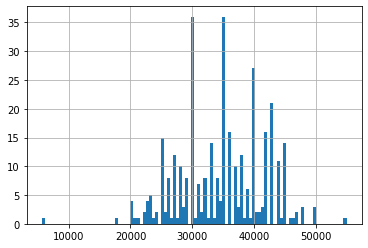

In [84]:
deposit_only_danji_df['보증금(만원)'].hist(bins=100)

In [86]:
monthly_pay_danji_df['월세를전세로'].describe()

count       76.000000
mean     23660.526316
std       6746.042375
min       7000.000000
25%      19000.000000
50%      23000.000000
75%      29125.000000
max      38000.000000
Name: 월세를전세로, dtype: float64

<AxesSubplot:>

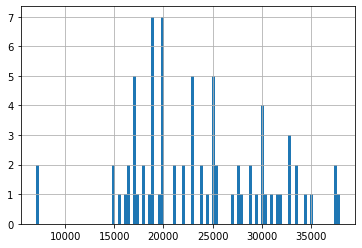

In [87]:
monthly_pay_danji_df['월세를전세로'].hist(bins=100)

## 가격/면적 log 로 이상치를 제거하는것이 더 일관성이 있다고 판단되므로 이걸로 결정